# Model performance metrics for KNN

Evaluate the performance of a KNN (K Nearest Neibours) on the MNIST dataset.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

Using hand-written images (MNSIT), explore the performance metrics of classifiers. 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
# MNIST dataset is a dictonary where each key identifies the type of data.
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
# DESCR refers to the explanation of the data set
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [11]:
# 'target' refers to the labels (digit of the handwritten image) and the 1st image is digit '5'.
# Convert character digit to int for ML.
mnist['target'] = mnist['target'].astype(np.int)
NUM_CLASSES = len(set(mnist['target']))

print("Number of labels [{}]".format(NUM_CLASSES))
print("First 10 labels {}".format(mnist['target'][:10]))

Number of labels [10]
First 10 labels [5 0 4 1 9 2 1 3 1 4]


In [5]:
# 'data' refers to an array of the hand-written images (70,000 images).
mnist['data'].shape

(70000, 784)

In [6]:
# Each image is 28 x 28 black & white bitmap.
mnist['data'][0].shape

(784,)

In [7]:
# 'feature_names' refers to description of each column of the image data e.g. mnist['data'][0].
#mnist['feature_names']

## Train and test data sets
MNIST data has been already shuffled, hence no need to shuffle.

In [8]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [40]:
# Binarize labels for precision-recall and roc curves for each class. 
from sklearn.preprocessing import label_binarize
Y = label_binarize(mnist.target, classes=[*range(NUM_CLASSES)])
Y_train, Y_test = Y[:60000], Y[60000:]

print(Y_test.shape)

(10000, 10)
[0 0 0 ... 0 0 0]


# Grid Search optimal hyper parameters and the classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(
    n_neighbors=NUM_CLASSES, 
    weights='uniform',
    n_jobs=-1           # Use all processors
)

params_knn = knn.get_params()
print("KNN parameters = {}".format(params_knn))

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'weights': ["uniform", "distance"], 
        'n_neighbors': [NUM_CLASSES]
    }
]
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
knn = grid_search.best_estimator_

print("GridSearchCV best parameters for KNN is {}".format(grid_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 62.4min remaining: 145.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 64.3min remaining: 27.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 64.4min finished


{'n_neighbors': 10, 'weights': 'distance'}


In [15]:
grid_search

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [16]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='distance')

# Prediction on Test Dataset

In [17]:
y_test_pred_knn = knn.predict(X_test)

# Confusion Matrix

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred_knn)

array([[ 972,    1,    1,    0,    0,    2,    3,    1,    0,    0],
       [   0, 1132,    2,    0,    0,    0,    1,    0,    0,    0],
       [  13,   10,  983,    2,    1,    0,    2,   17,    4,    0],
       [   0,    3,    1,  975,    1,   12,    1,    7,    5,    5],
       [   1,   11,    0,    0,  940,    0,    4,    1,    1,   24],
       [   4,    0,    0,    4,    2,  868,    6,    1,    1,    6],
       [   6,    4,    0,    0,    3,    2,  943,    0,    0,    0],
       [   0,   25,    3,    0,    1,    0,    0,  987,    0,   12],
       [   6,    4,    4,   10,    6,    8,    3,    6,  919,    8],
       [   5,    6,    3,    5,    8,    4,    1,   10,    2,  965]])

## Evaluation scores

In [58]:
from sklearn.metrics import accuracy_score
accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

In [59]:
from sklearn.metrics import precision_recall_fscore_support as score
precision_knn, recall_knn, fscore_knn, support_knn = score(y_test, y_test_pred_knn)

import pandas as pd
data_knn = [
#    np.append(["Accracy"], accuracy_knn),
    np.append(["Precision"], precision_knn),
    np.append(["Recall"], recall_knn),
    np.append(["F1"], fscore_knn),
    np.append(["Support"], support_knn)
]
pd.DataFrame(data_knn)

,0,1,2,3,4,5,6,7,8,9,10
0,Precision,0.9652432969215492,0.9464882943143813,0.9859578736208626,0.9789156626506024,0.9771309771309772,0.96875,0.9782157676348547,0.958252427184466,0.9860515021459227,0.946078431372549
1,Recall,0.9918367346938776,0.9973568281938326,0.9525193798449613,0.9653465346534653,0.9572301425661914,0.9730941704035875,0.9843423799582464,0.9601167315175098,0.9435318275154004,0.956392467789891
2,F1,0.9783593356819327,0.9712569712569713,0.9689502217841302,0.9720837487537388,0.9670781893004116,0.9709172259507831,0.9812695109261186,0.9591836734693878,0.9643231899265478,0.9512074913750616
3,Support,980,1135,1032,1010,982,892,958,1028,974,1009


## Precision Recall Curve

In [60]:
# --------------------------------------------------------------------------------
# For Precision-Recall and ROC, use predict_proba to get class probabilities (scores).
# --------------------------------------------------------------------------------
y_scores_knn = knn.predict_proba(X_test)
print("y_scores_knn shape is {}".format(y_scores_knn.shape))

y_scores_knn shape is (10000, 10)


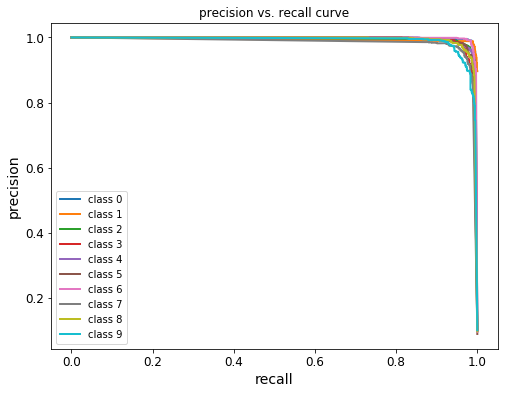

In [61]:
# --------------------------------------------------------------------------------
# https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
# For multi class curves, considering each element of the label indicator matrix 
# as a binary prediction (micro-averaging).
# --------------------------------------------------------------------------------
from sklearn.metrics import precision_recall_curve
def plot_precision_vs_recall_muliti_class(y, y_scores, num_classes):
    precisions = dict()
    recalls = dict()
    thresholds = dict()

    for i in range(num_classes):
        precisions[i], recalls[i], thresholds[i] = precision_recall_curve(
            y[:, i],
            y_scores[:, i]
        )
        plt.plot(recalls[i], precisions[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()
    
# --------------------------------------------------------------------------------
# [Draw P-R curve]
# --------------------------------------------------------------------------------
plt.figure(figsize=(8, 6)) 
plot_precision_vs_recall_muliti_class(Y_test, y_scores_knn, NUM_CLASSES)

## ROC

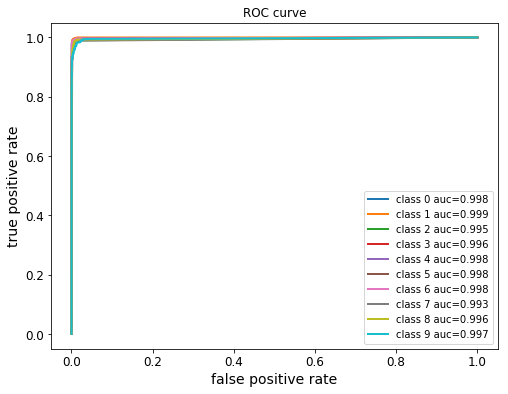

Saving figure roc_curve_plot_knn_multi_class


<Figure size 432x288 with 0 Axes>

In [62]:
# --------------------------------------------------------------------------------
# https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
# For multi class curves, considering each element of the label indicator matrix 
# as a binary prediction (micro-averaging).
# --------------------------------------------------------------------------------
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()

def plot_roc_curve_multi_class(y, y_scores, n_classes):
    for i in range(n_classes):

        fpr[i], tpr[i], threshold[i] = roc_curve(
            y[:, i],
            y_scores[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(
            fpr[i], 
            tpr[i], 
            lw=2, 
            label='class {0} auc={1}'.format(i, np.round(roc_auc[i], decimals=3))
        )
        
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()

# --------------------------------------------------------------------------------
# Draw ROC curve
# --------------------------------------------------------------------------------
plt.figure(figsize=(8, 6)) 
plot_roc_curve_multi_class(Y_test,y_scores_knn, NUM_CLASSES)
save_fig("roc_curve_plot_knn_multi_class") 

# Export Models

In [63]:
%%bash
pip install joblib

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
# https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html
import joblib
joblib.dump(knn, './mnist_knn.pkl', compress=3)

['./mnist_knn.pkl']

In [65]:
%%bash
pwd

/home/ec2-user/SageMaker/Probabilistic-ML
